<a href="https://colab.research.google.com/github/catebarry/mechanistic-interp/blob/main/mechanistic_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment 8: Mechanistic Interpretability
### Catie Barry
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catebarry/mechanistic-interp/blob/main/mechanistic_interp.ipynb)

## Description
We train a small MLP to predict the parity of the number of 1s in an 8-bit binary string then analyze the internals of the model using several mechanistic interpretability methods.

**Question:** Which neurons are involved in detecting parity, and how do the neurons encode information about parity?

**Hypothesis:** There will likely be some neuron or combination of neurons that encode parity through symmetric or alternating patterns.

**Methods:**
* Training a small MLP to solve a classification task (predicting the parity of the count of 1s)

* Visualizing hidden layer activations averaged by class (parity)

* Inspecting activations for specific inputs

* Neuron ablation (single-neuron) to test functional role

* Neuron ablation sweep across hidden neurons for a test input

* Global ablation importance

* Neuron selectivity curves (activation vs exact count)

* Inspecting fc1 weights

**Sources:**
* This notebook builds on [starter code](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/mechanistic_interp_starter.ipynb) provided by Dr. Bent
* AI assistance noted throughout comments and in statement at end of notebook

In [30]:
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "mechanistic-interp"
git_path = 'https://github.com/catebarry/mechanistic-interp.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = ''
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'mechanistic-interp'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
/content/mechanistic-interp
README.md


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
import os

In [35]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

OUTDIR = "interp_outputs"
os.makedirs(OUTDIR, exist_ok=True)

MODEL_PATH = "parity_model.pth"

### Data Generation

In [36]:
def generate_binary_data(n_samples=10000, seq_length=8):
    X = []
    y_count = []
    y_parity = []
    for _ in range(n_samples):
        binary_str = [random.choice([0, 1]) for _ in range(seq_length)]
        c = sum(binary_str)
        par = c % 2 # 0 even, 1 odd
        X.append(binary_str)
        y_count.append(c)
        y_parity.append(par)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y_count, dtype=torch.long), torch.tensor(y_parity, dtype=torch.float32)

seq_length = 8
X_train, y_count_train, y_parity_train = generate_binary_data(3000, seq_length)
X_val, y_count_val, y_parity_val = generate_binary_data(800, seq_length)

print("Shapes:", X_train.shape, y_count_train.shape, y_parity_train.shape)

Shapes: torch.Size([3000, 8]) torch.Size([3000]) torch.Size([3000])


### Build a Tiny MLP (multilayer perceptron) Model

In [37]:
# parity classifier model
class ParityMLP(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=12):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h_pre = self.fc1(x)
        h = F.relu(h_pre)
        logit = self.fc2(h).squeeze(-1)
        prob = torch.sigmoid(logit)
        return prob, logit, h, h_pre

model = ParityMLP(input_dim=seq_length, hidden_dim=12)
print(model)

ParityMLP(
  (fc1): Linear(in_features=8, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=1, bias=True)
)


In [45]:
# train model with binary cross entropy
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
    print(f"Loaded saved model from {MODEL_PATH}. Skipping training.")
else:
    print("No saved model found. Training a new model...")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    bce = nn.BCELoss()

    n_epochs = 200
    losses = []
    for ep in range(n_epochs):
        model.train()
        probs, logits, h, hpre = model(X_train)
        loss = bce(probs, y_parity_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (ep+1) % 20 == 0:
            print(f"Epoch {ep+1}/{n_epochs} loss {loss.item():.4f}")

    # save trained weights for reproducible analysis
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Training finished. Saved model to {MODEL_PATH}")

Loaded saved model from parity_model.pth. Skipping training.


In [46]:
# evaluation
model.eval()
with torch.no_grad():
    probs_val, logits_val, h_val, hpre_val = model(X_val)
    preds_val = (probs_val >= 0.5).long()
    acc = (preds_val == y_parity_val.long()).float().mean().item()

print("Final train loss:", losses[-1])
print("Val accuracy (parity):", acc)

Final train loss: 0.598127543926239
Val accuracy (parity): 0.7037500143051147


Because this model is relatively small, the accuracy is only 70%, but this should be enough to find (imperfect) patterns about how the model makes predictions.

### Print Activations of a sample input

In [47]:
with torch.no_grad():
    sample_input = torch.tensor([[1, 0, 0, 0, 1, 1, 0, 0]], dtype=torch.float32)
    prob, logit, hidden_post, hidden_pre = model(sample_input)


print(f"Sample Input: {sample_input}")
print(f"Hidden (pre-ReLU): {hidden_pre}")
print(f"Hidden (post-ReLU): {hidden_post}")
print(f"Output Logit: {logit.item():.4f}")
print(f"Predicted Probability (odd parity): {prob.item():.4f}")

# Convert to a hard class prediction (0=even, 1=odd)
predicted_class = int(prob.item() >= 0.5)
print(f"Predicted Parity Class: {predicted_class}")


Sample Input: tensor([[1., 0., 0., 0., 1., 1., 0., 0.]])
Hidden (pre-ReLU): tensor([[ 9.5873e-01,  2.5524e-03,  2.8256e-01, -1.0571e+00,  6.1172e-01,
          7.6564e-03, -4.8544e-03, -1.4358e+00,  6.4081e-01,  1.2163e-03,
         -1.0982e+00,  4.6944e-03]])
Hidden (post-ReLU): tensor([[0.9587, 0.0026, 0.2826, 0.0000, 0.6117, 0.0077, 0.0000, 0.0000, 0.6408,
         0.0012, 0.0000, 0.0047]])
Output Logit: 1.3603
Predicted Probability (odd parity): 0.7958
Predicted Parity Class: 1


The hidden layer activations tell us which neurons fired for the specific pattern. The logit is the raw, pre-sigmoid score (negative predicts even). The probability is sigmoid(logit), so 0.79 means the model thinks the sequence has an odd number of 1's (because it is >0.5 threshold).

### Plot hidden activations across parity of numbers of 1s as input

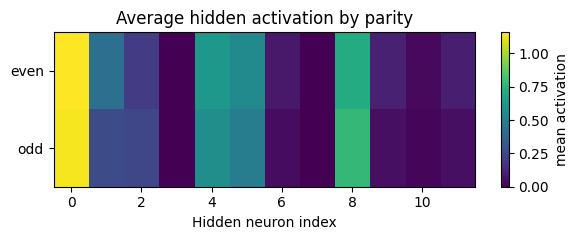

Saved parity heatmap to interp_outputs/avg_activation_by_parity.png


In [48]:
# average hidden activations by parity

with torch.no_grad():
    probs_val, logits_val, h_val, hpre_val = model(X_val)
h_np = h_val.numpy()

parities = y_parity_val.numpy().astype(int)
avg_by_parity = np.vstack([h_np[parities==c].mean(axis=0) for c in (0,1)])

plt.figure(figsize=(6,2.5))
plt.imshow(avg_by_parity, aspect='auto', cmap='viridis')
plt.yticks([0,1], ["even", "odd"])
plt.xlabel("Hidden neuron index")
plt.title("Average hidden activation by parity")
plt.colorbar(label="mean activation")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "avg_activation_by_parity.png"))
plt.show()
print(f"Saved parity heatmap to {os.path.join(OUTDIR, 'avg_activation_by_parity.png')}")

The parity heatmap shows that most neurons activate similarly across even and odd classes, with only small differences in brightness between the classes (for instance at hidden neuron 1 and 8). This suggests that the network has not formed distinct class-selective features and may be representing parity in a more distributed manner. Neuron 0 activates the most across all the neurons, followed by neuron 8, 4, and 5, yet there is little apparent difference in those activations between even and odd classes.

### Neuron Ablation (single neuron)

Let's try ablating neuron 0, given that it has the highest activation and likely influences model prediction the most.

In [49]:
# Sample input to test
test_input = torch.tensor([[1, 0, 1, 1, 0, 0, 1, 0]], dtype=torch.float32)  # Example: 4 ones, even parity
true_count = int(test_input.sum().item())
true_parity = true_count % 2

# Baseline prediction
model.eval()
with torch.no_grad():
    prob_base, logit_base, h_base_post, h_base_pre = model(test_input)
base_prob = prob_base.item()
base_class = int(base_prob >= 0.5)

print("Test input:", test_input.numpy())
print(f"True count: {true_count}, True parity: {true_parity}")
print(f"Baseline prob(odd): {base_prob:.4f} (class {base_class})")

# Zero out one neuron in the hidden layer (e.g., neuron 3)
neuron_to_zero = 0

# Manually run forward pass with neuron ablated
with torch.no_grad():
    h_pre = model.fc1(test_input)
    h_post = F.relu(h_pre.clone())
    # zero the selected neuron
    h_post_ablated = h_post.clone()
    h_post_ablated[:, neuron_to_zero] = 0.0
    # compute new logit and prob
    logit_mod = model.fc2(h_post_ablated).squeeze().item()
    prob_mod = torch.sigmoid(torch.tensor(logit_mod)).item()
    class_mod = int(prob_mod >= 0.5)

print(f"\nAblating neuron {neuron_to_zero}:")
print(f"  New prob(odd): {prob_mod:.4f} (class {class_mod})")


delta = prob_mod - base_prob
print(f"\nDelta prob(odd) = {delta:+.4f}")

if class_mod != base_class:
    print("Class flipped after ablation")
else:
    print("No class flip after ablation")

Test input: [[1. 0. 1. 1. 0. 0. 1. 0.]]
True count: 4, True parity: 0
Baseline prob(odd): 0.3773 (class 0)

Ablating neuron 0:
  New prob(odd): 0.5070 (class 1)

Delta prob(odd) = +0.1297
Class flipped after ablation


Ablating neuron 0 increased the model's predicted probability of odd from 0.37 to 0.50, which is quite significant--and was sufficient to flip the parity prediction from even (correct) to odd (incorrect). Thus, this neuron likely plays an important functional role in the model's decision.

### Neuron Ablation (sweep of neurons)

Test input: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]  True count: 8, true parity: 0
Baseline P(odd): 0.5269  Baseline class: 1 ('1' means odd)


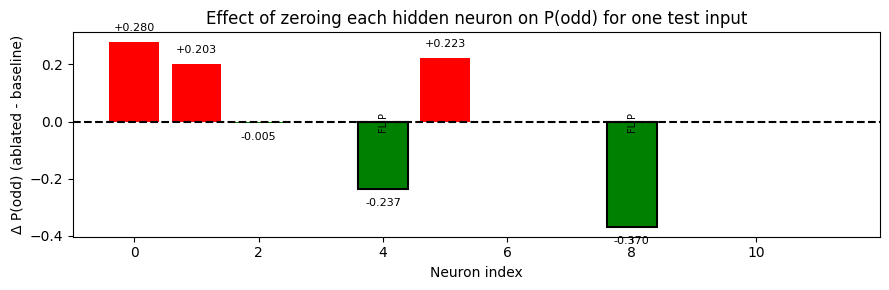

 neuron  0: ΔP=+0.280, flip=no
 neuron  1: ΔP=+0.203, flip=no
 neuron  2: ΔP=-0.005, flip=no
 neuron  4: ΔP=-0.237, flip=YES
 neuron  5: ΔP=+0.223, flip=no
 neuron  8: ΔP=-0.370, flip=YES


In [64]:
# Block of code generated by ChatGPT 5.0 on 11/10/25 at 11:00 pm

# Sample input to test
test_input = torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.float32)
true_count = int(test_input.sum().item())
true_parity = true_count % 2

# Baseline prediction
model.eval()
with torch.no_grad():
    prob_base, logit_base, h_base_post, h_base_pre = model(test_input)
base_prob = float(prob_base.item())
base_class = int(base_prob >= 0.5)

print(f"Test input: {test_input.numpy().tolist()[0]}  True count: {true_count}, true parity: {true_parity}")
print(f"Baseline P(odd): {base_prob:.4f}  Baseline class: {base_class} ('1' means odd)")

# sweep ablation across all hidden neurons
hidden_dim = model.fc1.out_features
deltas = np.zeros(hidden_dim)
flips = np.zeros(hidden_dim, dtype=bool)

with torch.no_grad():
    h_pre = model.fc1(test_input)
    h_post = F.relu(h_pre.clone())
    for i in range(hidden_dim):
        h_mod = h_post.clone()
        h_mod[:, i] = 0.0
        logit_mod = model.fc2(h_mod).squeeze().item()
        prob_mod = float(torch.sigmoid(torch.tensor(logit_mod)).item())
        deltas[i] = prob_mod - base_prob
        flips[i] = (int(prob_mod >= 0.5) != base_class)

plt.figure(figsize=(9,3))
colors = ['red' if d > 0 else 'green' if d < 0 else 'gray' for d in deltas]
bars = plt.bar(np.arange(hidden_dim), deltas, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Neuron index")
plt.ylabel("Δ P(odd) (ablated - baseline)")
plt.title("Effect of zeroing each hidden neuron on P(odd) for one test input")

# annotate values and mark flips with black edge
for i, bar in enumerate(bars):
    height = deltas[i]
    if abs(height) > 1e-3:
        plt.text(i, height + (0.03 if height>0 else -0.03), f"{height:+.3f}",
                 ha='center', va='bottom' if height>0 else 'top', fontsize=8)
    if flips[i]:
        bar.set_edgecolor('k')
        bar.set_linewidth(1.5)
        plt.text(i, 0.0, "FLIP", ha='center', va='center', color='k', fontsize=7, rotation=90)

plt.tight_layout()
plt.show()

# Summary
for i in range(hidden_dim):
    if abs(deltas[i]) > 1e-4 or flips[i]:
        flip_str = "YES" if flips[i] else "no"
        print(f" neuron {i:2d}: ΔP={deltas[i]:+0.3f}, flip={flip_str}")


For the example input [1,0,1,1,0,0,1,0] (count=4, parity=0, baseline P(odd)=0.3773), zeroing individual neurons revealed that:
- Ablating neuron 1 produced the largest change in P(odd) (+0.517 on this example), flipping the predicted class from even to odd.
- Ablating neuron 5 and 8 also produced notable changes, though smaller than neuron 1.
- Several neurons (e.g. 3, 6, 7, 9, 10) produced essentially no change when ablated for this input, indicating redundancy or little influence on model predictions.
These results makes sense with our previous finding, where there was slightly more activation/color difference between even and odd for neuron 1 and 8, but little difference for neuron 0--so while neuron 0 shows high activation, ablating it can actually flip the prediction

This makes sense with the previous finding, where there was slightly more activation difference between even and odd for neuron 1 compared to neuron 0, for instance, which showed high activation but little difference between activation for even and odd classes.

Running the ablation sweep on other representative inputs gave similar results: neuron 1 and 8 consistently produced the largest changes in probability predictions on many examples. These neurons likely are the most influential in determining parity--though perhaps with subtle differences in when each is more influential. For instance:
- In the example [0,0,1,1,0,0,1,0] (count=3, parity=1), the original odd prediction is 0.3370, and neuron 1 has the largest effect, changing the prediction by +0.409.
- Neuron 1 again has the largest effect on predictions for the example [1,1,1,1,0,0,1,0] (count=5, parity=1), changing the prediction by +0.408.
- For the example [1,0,1,0,0,0,0,0] (count=2, parity=0), neuron 8 had the most signfiicant effect on the model's predictions (changed by -0.417).

These results suggest we should pay close attention to neurons 1 and 8, and particularly at the patterns when one is more influential in the decision than the other (which may differ based on count).

### Global Ablation Importance

This will compute for each neuron the average absolute change in P(odd) when that neuron is zeroed across the entire validation set. It also reports how many times ablating a neuron flips the class.

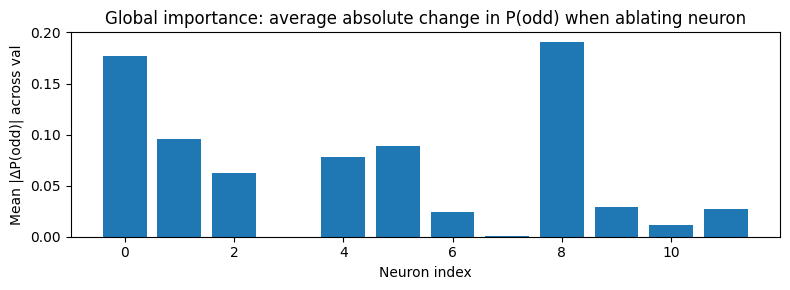

Neurons ranked by mean |ΔP| (top 6):
 neuron 8: mean |ΔP| = 0.1906, mean ΔP = -0.1906, flips = 251
 neuron 0: mean |ΔP| = 0.1766, mean ΔP = +0.1766, flips = 263
 neuron 1: mean |ΔP| = 0.0953, mean ΔP = +0.0953, flips = 160
 neuron 5: mean |ΔP| = 0.0893, mean ΔP = +0.0893, flips = 174
 neuron 4: mean |ΔP| = 0.0784, mean ΔP = -0.0784, flips = 147
 neuron 2: mean |ΔP| = 0.0628, mean ΔP = -0.0628, flips = 103


In [65]:
# Block of code generated by ChatGPT 5.0 on 11/10/25 at 11:00 pm
model.eval()
hidden_dim = model.fc1.out_features
V = X_val.shape[0]

# Precompute activations for speed
with torch.no_grad():
    probs_all, logits_all, h_all_post, h_all_pre = model(X_val)
h_all = h_all_post.numpy()
probs_base = probs_all.numpy()

# Accumulators
avg_abs_delta = np.zeros(hidden_dim)
avg_signed_delta = np.zeros(hidden_dim)
flip_counts = np.zeros(hidden_dim, dtype=int)

# Efficient sweep: iterate neuron's index, compute P_mod for all val quickly
with torch.no_grad():
    h_tensor = torch.tensor(h_all, dtype=torch.float32)
    for i in range(hidden_dim):
        h_mod = h_tensor.clone()
        h_mod[:, i] = 0.0
        logit_mod = model.fc2(h_mod).squeeze(-1)
        prob_mod = torch.sigmoid(logit_mod).numpy()
        delta = prob_mod - probs_base
        avg_abs_delta[i] = np.mean(np.abs(delta))
        avg_signed_delta[i] = np.mean(delta)
        flip_counts[i] = np.sum((prob_mod >= 0.5) != (probs_base >= 0.5))

# Plot mean absolute ΔP per neuron
plt.figure(figsize=(8,3))
bars = plt.bar(np.arange(hidden_dim), avg_abs_delta)
plt.xlabel("Neuron index")
plt.ylabel("Mean |ΔP(odd)| across val")
plt.title("Global importance: average absolute change in P(odd) when ablating neuron")
plt.tight_layout()
plt.show()

# Print ranking
rank = np.argsort(-avg_abs_delta)
print("Neurons ranked by mean |ΔP| (top 6):")
for r in rank[:6]:
    print(f" neuron {r}: mean |ΔP| = {avg_abs_delta[r]:.4f}, mean ΔP = {avg_signed_delta[r]:+.4f}, flips = {flip_counts[r]}")


This global ablation importance chart shows us that neuron 8 causes the most significant change in model predictions when we ablate it. This is followed by neuron 0, then 1. This makes sense with what we have observed so far--neuron 0 has the highest activations so it is likely influencing model outputs, even if it doesn't carry as much information on parity. And neurons 1 and 8 seem to play significant roles in parity prediction given the ablation observations previously, but perhaps they influence the model's decision to varying degrees depending on the count.

### Neuron Selectivity Curves

Plot the mean activation of each neuron for each exact count. This will show whether the neurons (especially paying attention to 1 and 8) respond to odd counts specifically or to some other pattern.

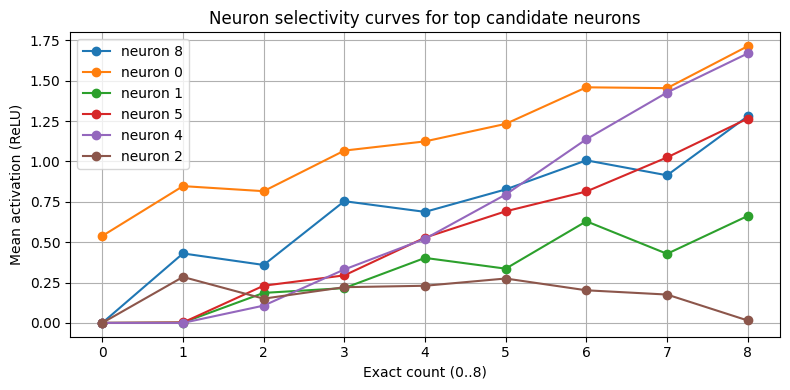

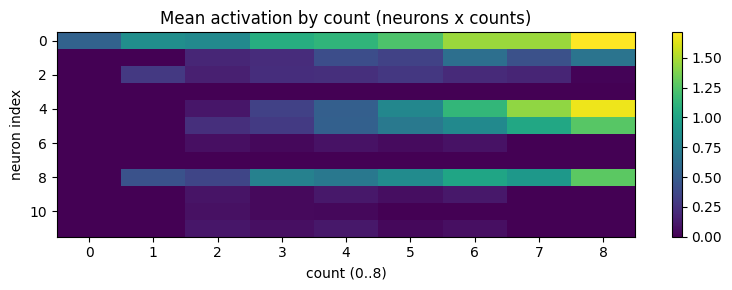

In [59]:
# Block of code generated by ChatGPT 5.0 on 11/10/25 at 11:00 pm
model.eval()
with torch.no_grad():
    _, _, h_val_post, _ = model(X_val)
h_np = h_val_post.numpy()
counts = y_count_val.numpy()

max_count = int(h_np.shape[0])
seq_len = X_val.shape[1]
count_range = np.arange(seq_len+1)
hidden_dim = h_np.shape[1]

# compute mean activation per count
mean_act = np.zeros((len(count_range), hidden_dim))
for c in count_range:
    sel = (counts == c)
    if np.sum(sel) > 0:
        mean_act[c] = h_np[sel].mean(axis=0)
    else:
        mean_act[c] = np.zeros(hidden_dim)

# plot for top few neurons or all
top_candidates = np.argsort(-avg_abs_delta)[:6]
plt.figure(figsize=(8,4))
for n in top_candidates:
    plt.plot(count_range, mean_act[:, n], label=f"neuron {n}", marker='o')
plt.xlabel("Exact count (0..8)")
plt.ylabel("Mean activation (ReLU)")
plt.title("Neuron selectivity curves for top candidate neurons")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("interp_outputs/selectivity_top_candidates.png")
plt.show()

# Heatmap of mean_act
plt.figure(figsize=(8,3))
plt.imshow(mean_act.T, aspect='auto', cmap='viridis')
plt.xlabel("count (0..8)")
plt.ylabel("neuron index")
plt.title("Mean activation by count (neurons x counts)")
plt.colorbar()
plt.tight_layout()
plt.savefig("interp_outputs/mean_activation_by_count_heatmap.png")
plt.show()


In these figures, we are looking for alternating patterns--zig zagging up and down trends in the neuron selectivity curve and symmetric color shifts for even and odd counts in the mean activation heatmap. Such patterns suggest that certain neurons are sensitive to parity, while smooth monotonic increases imply counting behavior.

**Neuron selectivity curve:**

Many neurons show steadily increasing activation with count, indicating that they encode some notion of count. This is most evident for neurons 5, 4, and 0, which display strong, nearly linear trends.

Neurons 1 and 8 also increase overall but exhibit a clear zig-zag pattern. Neuron 8 shows the strongest alternatation--rising on odd counts and dropping on even ones except near a count of 5 and 6--suggesting a link to parity detection, which may not be as clear of a signal where the zig zag pattern is less distinct around 5 and 6. Neuron 8 has the clearest zig zag pattern near lower counts. Neuron 1 shows a similar oscillation, but it is most distinct around higher counts of 5 and 6 (perhaps compensating where neuron 8 struggles to separate classes) and less clear for lower counts. It has lower overall activations.

Neuron 0, while generally most active, follows more of a step-like trend rather than an alternating one, consistent with a count-like feature that may encode some information about parity.

**Mean activation count heatmap:**

The heatmap supports these observations. Some neurons are dark across counts, implying they're largely inactive or redundant. Others (neurons 0, 4, 5) brighten steadily with count, again consistent with count encoding. A few neurons (notably 1 and 8) alternate between lighter and darker shades across neighboring counts (even as their overall activation increases with count), suggesting parity-sensitive behavior. For neuron 1, the color alternation is most clear for higher counts. For neuron 8, the alternating patterns are most clear for lower counts.

**Hypothesis:**

*Overall, these trends indicate that neuron 8 and 1 are most directly involved in parity detection, but compensate for each other depending on the count: neuron 8 may influence the model's decision more when count is lower, and neuron 1 may influence the decision more for higher counts.*

### Inspect fc1 weights for top neurons

This shows which input bit positions have large positive/negative weights into the neuron. For parity, symmetric patterns or alternating signs are of interest.

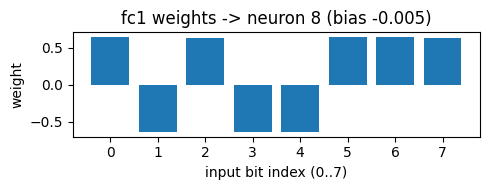

Saved interp_outputs/fc1_weights_neuron_8.png


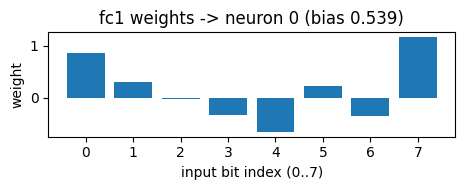

Saved interp_outputs/fc1_weights_neuron_0.png


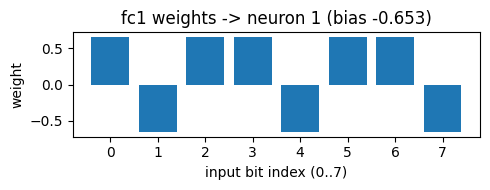

Saved interp_outputs/fc1_weights_neuron_1.png


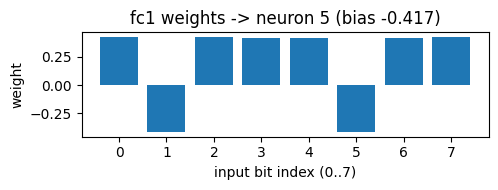

Saved interp_outputs/fc1_weights_neuron_5.png


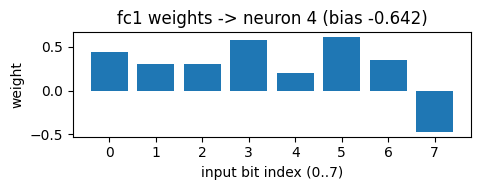

Saved interp_outputs/fc1_weights_neuron_4.png


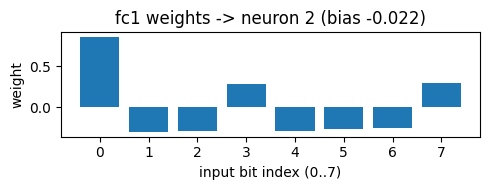

Saved interp_outputs/fc1_weights_neuron_2.png


In [60]:
# Block of code generated by ChatGPT 5.0 on 11/10/25 at 11:00 pm

w_fc1 = model.fc1.weight.detach().numpy()
b_fc1 = model.fc1.bias.detach().numpy()

# pick top k neurons from global importance ranking (or use [1] if you know it)
try:
    top_k = list(rank[:6])
except NameError:
    top_k = [1] + list(np.argsort(-np.abs(w_fc1).sum(axis=1))[:5])

for n in top_k:
    plt.figure(figsize=(5,2))
    plt.bar(np.arange(w_fc1.shape[1]), w_fc1[n])
    plt.xlabel("input bit index (0..7)")
    plt.ylabel("weight")
    plt.title(f"fc1 weights -> neuron {n} (bias {b_fc1[n]:.3f})")
    plt.tight_layout()
    fname = f"interp_outputs/fc1_weights_neuron_{n}.png"
    plt.savefig(fname)
    plt.show()
    print(f"Saved {fname}")


The fc1 weights further support our hypothesis. Several neurons have mostly positive and similar weights, indicating that those neurons sum bits (like a count)--especially neurons 4 and 5.

Other neurons show a flip between positive and negative weights for different counts, indicating that they could play a role in predicting parity. This pattern is especially true for neurons 1 and 8, which alternate between positive and negative weights more than the other neurons.

## Reflection

Through this investigation, I wanted to understand **which neurons detect parity and how the network internally represents parity information.**

Based on the analysis, I developed the following mechanistic hypothesis: **neurons 1 and 8 are most directly involved in parity detection, complementing each other depending on the count of 1s--neuron 1 is more sensitive to parity for higher counts, while neuron 8 is more sensitive for lower counts.**

From this work, I learned that even a small MLP can encode seemingly simple concepts like parity in surprisingly complex ways (that in this case remain interpretable). While the task of judging even vs. odd feels trivial/intuitive to us as humans, the model represents it through distributed patterns of activations and overlapping features--some neurons track count-like information, while others encode alternating, parity-specific signals which may differ in strength depending on the count.

What surprised me most was that neurons with the largest activations (like neuron 0) were not always the most important for parity decisions, whereas neurons with smaller activations (like neuron 1) could play an influential role. It was also interesting that different methods (including activation heatmaps, ablations, and sensitivity curves) generally pointed to the same few neurons, though not with perfect agreement (which could be in part due to the imperfect model accuracy).

The most challenging part was deciding which interpretability methods would reveal meaningful patterns, as some provided ambiguous results or didn't provide much information--which I could only realize after trying them out.

I'd love to explore how these representations change during training or whether the same neurons remain important across random initializations. It would also be interesting to test whether parity-sensitive neurons emerge more clearly in larger networks or different architectures--for instance, at a neuron in a later hidden layer could have a more clear parity encoding.

## AI Assistance Statement

Portions of this notebook were developed with assistance from OpenAI's ChatGPT 5.0 (November 2025). All generated code and explanations were reviewed, tested, and edited to ensure correctness and alignment with assignment requirements.

Specific dates/times and prompts to generate code blocks are listed below:


| **Date / Time (EST)** | **Summary of Prompt / Request** | **Code or Text Generated / Modified** |
|------------------------|---------------------------------|--------------------------------------|
| **Nov 10 2025 – 7:30 PM** | Asked how to design a custom parity classification model based on the provided starter code. | Generated initial parity-MLP architecture, training loop, and evaluation logic adapted from the starter counting example. |
| **Nov 10 2025 – 8:15 PM** | Requested help inspecting activations and visualizing hidden layer behavior. | Produced code to print pre-/post-ReLU activations for a sample input and to plot average hidden activations by parity class. |
| **Nov 10 2025 – 9:00 PM** | Asked for neuron ablation methods compatible with the parity model. | Provided single-neuron ablation and sweep-of-neurons code measuring ΔP(odd) and class flips. |
| **Nov 10 2025 – 10:00 PM** | Requested additional interpretability techniques. | Generated code for global ablation importance, neuron selectivity curves (activation vs count), and visualization of fc1 weight patterns. |
